# SVD and t-SNE

We'll now build some document vectors and run SVD on the vectors. We will then visualize our dense document vectors.

We will start by generating a dataset of Brown documents. We will only consider documents from five categories (listed in `CATEGORIES`).

In [2]:
import nltk
from nltk.corpus import brown,stopwords
from collections import Counter

EN_STOPWORDS = set(stopwords.words("english"))
CATEGORIES = ["adventure", "fiction", "government", "editorial", "hobbies"]
DOCNAMES = brown.fileids(categories=CATEGORIES)
DOCNAME2IND = {name:i for i, name in enumerate(DOCNAMES)}

def preprocess(text):
    # Lower-case all words and filter out stop words 
    return [w.lower() for w in text if not w.lower() in EN_STOPWORDS]

data = [" ".join(preprocess(brown.words(fileid))) for fileid in DOCNAMES]

We will now transform our word lists to sparse document vectors using `CountVectorizer`.

We get 151 documents and 22104 word types in the vocabulary.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

X = CountVectorizer().fit_transform(data).toarray()

print(X.shape)

(151, 22104)


In [5]:
X[0]

array([0, 3, 0, ..., 0, 0, 0])

> There are a lot of 0s in the vector.

Let's then test a few document vectors to see their cosine distance (note, this is 1 - cosine similarity). Therefore, we would expect a larger cosin distance when two documents are not very related.

 We will test the two first adventure and government documents.

In [6]:
len(DOCNAME2IND) # notice the len == X.shape[0]

151

In [7]:
from scipy.spatial.distance import cosine

# get the ids of the brown files
adv1 = brown.fileids(categories="adventure")[0]
adv2 = brown.fileids(categories="adventure")[1]
gov1 = brown.fileids(categories="government")[0]
gov2 = brown.fileids(categories="government")[1]

# get the corresponding embedding vector
adv_v1 = X[DOCNAME2IND[adv1]]
adv_v2 = X[DOCNAME2IND[adv2]]
gov_v1 = X[DOCNAME2IND[gov1]]
gov_v2 = X[DOCNAME2IND[gov2]]

print(cosine(adv_v1, adv_v2))
print(cosine(gov_v1, gov_v2))
print(cosine(gov_v1, adv_v2))

0.7059782910623575
0.8126515014618292
0.9716017288115013


We'll now transform word counts to tf-idf weights using `TfidfTransformer`. We'll also normalize all vectors to unit length.

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize

X_tfidf = TfidfTransformer().fit_transform(X).toarray()   # call toarray() to get a numpy array
X_tfidf = normalize(X_tfidf,axis = 1)  
# it's good idea to normalize because documents are not of same length, default axis = 1 (for each row)
X_tfidf.shape

(151, 22104)

In [10]:
X_tfidf[0]

array([0.        , 0.04104794, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [9]:
adv_v1 = X_tfidf[DOCNAME2IND[adv1]]
adv_v2 = X_tfidf[DOCNAME2IND[adv2]]
gov_v1 = X_tfidf[DOCNAME2IND[gov1]]
gov_v2 = X_tfidf[DOCNAME2IND[gov2]]

print(cosine(adv_v1, adv_v2))
print(cosine(gov_v1, gov_v2))
print(cosine(gov_v1, adv_v2))

0.9017813919297932
0.8685796603168909
0.9938641312026681


Let's then transform our sparse 20k-dimensional vectors to dense vectors using Truncated SVD. 

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
X_dense_100 = svd.fit_transform(X_tfidf)

In [13]:
X_dense_100[0]

array([ 0.33114654,  0.23953682,  0.07146153,  0.08743511,  0.0325936 ,
       -0.09090816, -0.04388721,  0.00828214, -0.01077534,  0.01765412,
       -0.01215301, -0.0164915 ,  0.07075435,  0.02259974, -0.06246337,
       -0.007122  ,  0.09272631, -0.06124149, -0.0587969 ,  0.00980453,
        0.04040729,  0.06604114,  0.11036266, -0.00035715, -0.08644397,
       -0.00574529, -0.00583392,  0.1377526 , -0.11391618,  0.03160783,
        0.08255607, -0.11784265, -0.06161446, -0.11982067,  0.03027676,
        0.02869632,  0.06826043, -0.03106842,  0.05973311,  0.06071712,
        0.01709456,  0.09314962, -0.08893745, -0.05555557, -0.04102566,
       -0.03876211,  0.11292559, -0.03410717, -0.07366432,  0.04374795,
       -0.01295442,  0.00416905, -0.07209262, -0.10642151,  0.00925934,
        0.04998166,  0.0377307 ,  0.05129783,  0.04557755,  0.09563376,
        0.09691161, -0.05793476, -0.02542732, -0.02842525,  0.05477851,
       -0.00808224, -0.01465902, -0.05529424,  0.03436992,  0.02

The singular values tell us how much each extra dimension adds to the approximation of the original matrix. We can use them to pick a reduced dimensionality.

We'll now plot the singular values and try to find a suitable value for the reduced dimensionality of the dense vectors. Just as in clustering, we can try to find the elbow in the singular value graph. This is called Cattell's scree test. 

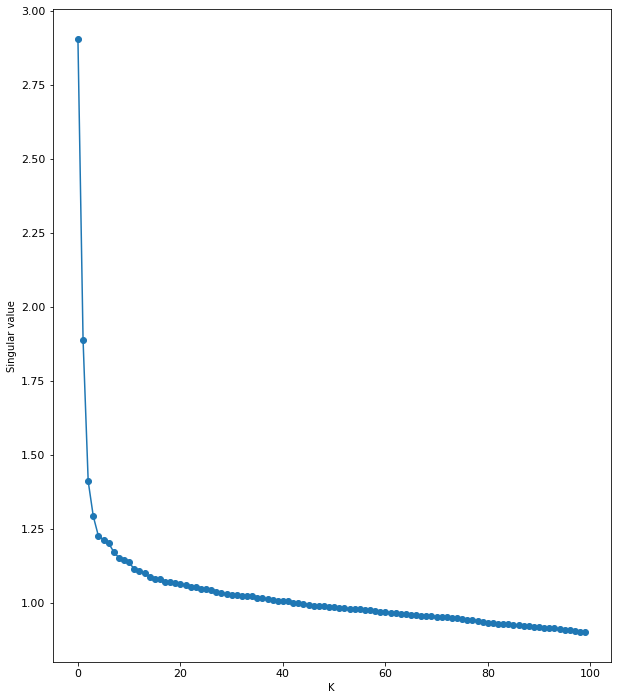

In [15]:
import matplotlib.pyplot as plt 
def plot_svd(svd):
    ''' plot the singular values of the provided singular value decomposition. No return value'''
    w = 10
    h = 12
    plt.figure(figsize = (w,h))
    # get singular values by calling svd.singular_values_
    plt.plot(range(len(svd.singular_values_)),svd.singular_values_ , '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Singular value", fontsize=w)
    
plot_svd(svd)

We will pick a value k=20.

In [16]:
X_dense = X_dense_100[:,:20]
print(X_dense.shape)

(151, 20)


Let's examine cosine distances again. We can now see that cosine distances between dense document vectors in the same category seems to be far lower after dimensionality reduction, while distance between clusters is still high. 

In [17]:
adv_v1 = X_dense[DOCNAME2IND[adv1]]
adv_v2 = X_dense[DOCNAME2IND[adv2]]
gov_v1 = X_dense[DOCNAME2IND[gov1]]
gov_v2 = X_dense[DOCNAME2IND[gov2]]

print(cosine(adv_v1, adv_v2))
print(cosine(gov_v1, gov_v2))
print(cosine(gov_v1, adv_v2))

0.43629989692192594
0.2709476996327863
0.9272404902509749


- Observations: whereas the figure of `cosine(gov_v1, adv_v2)` doesn't change much, the figure of `(adv_v1, adv_v2)` and `(gov_v1, gov_v2)` have a significant drop.

- Conclusion: here the dimensional reduction clearly pushes together documents of the same category and pushes further away documents that are not. It will be beneficial for us to cope with this new values becuase they are clearer.

Let's then plot the first two components of `X_dense`. This gives us a visualization of the data using SVD.

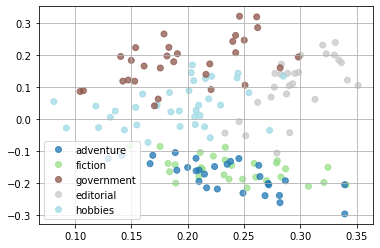

In [18]:
import matplotlib.pyplot as plt

BROWN_CATEGORIES = {fileid:i for i, cat in enumerate(CATEGORIES) for fileid in brown.fileids(categories=cat)}
    
fileids = brown.fileids()


def plot(X):
    # associate each color with each category to color them differently
    colors = [BROWN_CATEGORIES[fileid] for fileid in DOCNAMES]
    brown_cats = CATEGORIES    
    fig, ax = plt.subplots()
    # we are just considering the first two columns with the highest sigular columns
    scatter = ax.scatter(X[:,0], X[:,1], c=colors, label=colors, alpha=0.75, cmap="tab20")    
    ax.legend(handles=scatter.legend_elements()[0], labels=CATEGORIES)
    ax.grid(True)
    plt.show()

X_2d = X_dense[:,:2]
plot(X_2d)

> The axis number doesn't mean much, but the plot does tell us that the `adventure` and the `fiction` are kind of similar to each other because many points are actually intertwined.

We can also visualize using t-SNE

/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(151, 2)


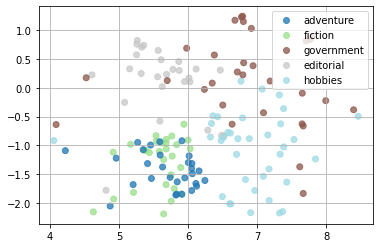

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# n_components = dim of visualization
X_2d_tsne = TSNE(n_components=2, perplexity=100, n_iter=5000, init='random').fit_transform(X_dense)
print(X_2d_tsne.shape)
plot(X_2d_tsne)

Here it's more clear that `adventure` and the `fiction` are somewhat similar.

**Important: these plots are just visualizations, we should not trust the numbers much. But it's a very good way to visaulize our data structure. There are too many parameters under the hook that will affect the result graph. Also it's a heuristic approach, so again we should not trust the numbers too much.**